In [98]:
# Dashcam video of driving around San Francisco
video_url = "https://www.youtube.com/watch?v=PGMu_Z89Ao8"  

# Frames to skip
N = 120

In [ ]:
# pytube is used to download videos from YouTube
!pip install pytube

# Intall a newer version of plotly
!pip install --upgrade plotly

In [99]:
from pytube import YouTube

# Choose a video stream with resolution of 360p
streams = YouTube(video_url).streams.filter(adaptive=True, subtype="mp4", resolution="360p", only_video=True)

# Check if there is a valid stream
if len(streams) == 0:
  raise "No suitable stream found for this YouTube video!"

# Download the video as video.mp4
print("Downloading...")
streams[0].download(filename="video.mp4")
print("Download completed.")

Downloading...
Download completed.


In [101]:
import cv2
from PIL import Image

# The frame images will be stored in video_frames
video_frames = []

# Open the video file
capture = cv2.VideoCapture('video.mp4')
fps = capture.get(cv2.CAP_PROP_FPS)

current_frame = 0
while capture.isOpened():
  # Read the current frame
  ret, frame = capture.read()

  # Convert it to a PIL image (required for CLIP) and store it
  if ret == True:
    video_frames.append(Image.fromarray(frame[:, :, ::-1]))
  else:
    break

  # Skip N frames
  current_frame += N
  capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

# Print some statistics
print(f"Frames extracted: {len(video_frames)}")

Frames extracted: 962


In [102]:
from nos.client import InferenceClient, TaskType

# Create a client that connects to the inference server via gRPC (50051)
client = InferenceClient()
client.WaitForServer()
client.IsHealthy()

nos_embedding_module = client.Module(TaskType.IMAGE_EMBEDDING, "openai/clip")

In [167]:
import plotly.express as px
import datetime
from IPython.core.display import HTML
import torch

import math
import numpy as np

device = "cuda"

# The encoded features will be stored in video_features
video_features = np.empty([0, 512], dtype=np.float16)
# We don't yet support batched inference, so do this frame by frame (might take a while)
for frame in video_frames:
    with torch.no_grad():
        frame_features = nos_embedding_module(images=[np.asarray(frame)])['embedding']
        frame_features_normed = frame_features.copy()
        frame_features_normed /= np.linalg.norm(frame_features, axis=-1)
        # print(f"video features: {video_features}")
        # print(f"frame features: {frame_features}")
        video_features = np.concatenate((video_features, frame_features_normed))

print(f"Final video features: {video_features.shape}")

# Convert to torch tensor
torch_video_features = torch.from_numpy(video_features).type(torch.float32)

Final video features: (962, 512)


In [168]:
def encode_text_nos(search_query):
    with torch.no_grad():
        text_features = client.Run(TaskType.TEXT_EMBEDDING, "openai/clip", texts=[search_query])['embedding']
        # Convert to torch so we can use the same utils as the openAI clip module
        torch_text_features = torch.from_numpy(text_features)
        torch_text_features /= torch_text_features.norm(dim=-1, keepdim=True).to('cpu').type(torch.float32)
    return torch_text_features

def search_video(search_query, video_features, display_heatmap=True, display_results_count=3, encoder='NOS'):

    text_features = encode_text_nos(search_query)

    # Compute the similarity between the search query and each frame using the Cosine similarity
    similarities = (100.0 * video_features @ text_features.T)
    values, best_photo_idx = similarities.topk(display_results_count, dim=0)    
    
    # Display the heatmap
    if display_heatmap:
        print("Search query heatmap over the frames of the video:")
        fig = px.imshow(similarities.T, height=50, aspect='auto', color_continuous_scale='viridis')
        fig.update_layout(coloraxis_showscale=False)
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
        print()

    # Display the top 3 frames
    for frame_id in best_photo_idx:
        display(video_frames[frame_id])

        # Find the timestamp in the video and display it
        seconds = round(frame_id.cpu().numpy()[0] * N / fps)
        display(HTML(f"Found at {str(datetime.timedelta(seconds=seconds))} (link)"))

Search query heatmap over the frames of the video:


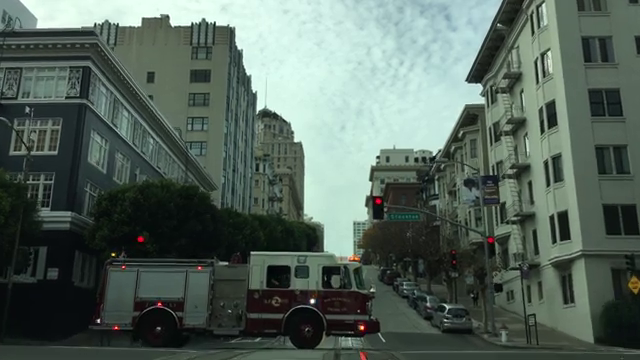

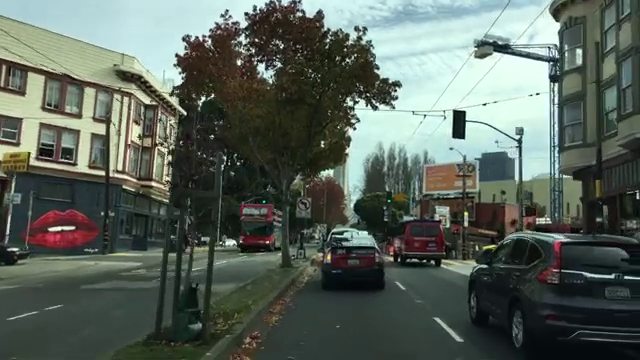

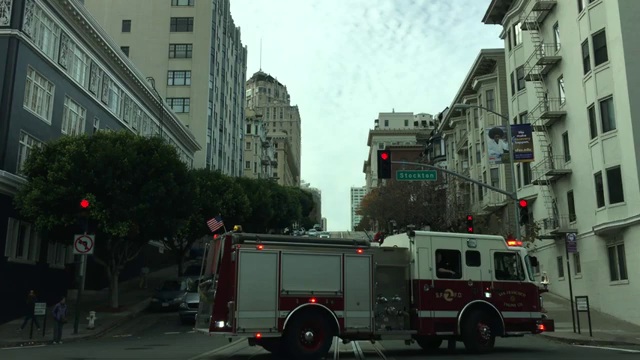

In [170]:
search_video("firetruck", torch_video_features)